<a href="https://colab.research.google.com/github/williamratcliff/APS-GDS-March-2024-Data-Science-Tutorial/blob/main/CNN/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network Tutorial
Author: Karan Shah

The module is divided into 3 parts:
1. Manipulating images - Setting up Kernels
2. Implementing a CNN in Pytorch
3. Examples of physics applications

## 1. Manipulating Images / Setting up kernels

In [1]:
# Get res dir and helper files
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    link = ""
    print("Colab detected. (Re)Loading resources from github")
    os.system("rm -rf images")
    os.system("rm -rf experiments")
    os.system("rm -f colab_archive.tar.gz")
    os.system(f"wget {link}")
    os.system("mv colab_archive.tar.gz?raw=true colab_archive.tar.gz")
    os.system("tar -xzf colab_archive.tar.gz")

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy as sp

from ipywidgets import interact
import ipywidgets as widgets

from tqdm import tqdm

In [3]:
# Helper functions

def get_pixels(image, gray=True):
    if gray:
        im = plt.imshow(image,
                        interpolation='none', vmin=0, vmax=1, aspect='equal', cmap='gray')
        n_y, n_x = image.shape
    else:
        im = plt.imshow(image,
                        interpolation='none', aspect='equal')
        n_y, n_x,_ = image.shape
    ax = plt.gca();



    ax.set_xticks(np.arange(0, n_x, 1))
    ax.set_yticks(np.arange(0, n_y, 1))

    ax.set_xticklabels(np.arange(0, n_x, 1))
    ax.set_yticklabels(np.arange(0, n_y, 1))

    ax.set_xticks(np.arange(-.5, n_x, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n_y, 1), minor=True)

    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

    ax.tick_params(which='minor', bottom=False, left=False)
    return ax

## 1. Introduction to Digital Images and Pixel Representation (What are images?)

Digital images are typically represented as arrays of pixels, where each pixel corresponds to a specific location in the image and stores color information. In this section, we will explore how digital images are represented as arrays of pixels and how to manipulate them using Python.

### Simplest example: Binary image

A binary image is simply a 2D array of 1s and 0s. Here 1s denote the color white (pixel on) and 0s denote the color black (pixel off). Let us design our first pixel art:

In [4]:
image = np.asarray([[1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.]])

Can you guess what the image is from its underlying array? We can use the `matplotlib.imshow(image_array)` function to visualize this array. We can also use the helper function `get_pixels(image_array)` to visualize our pixel art.

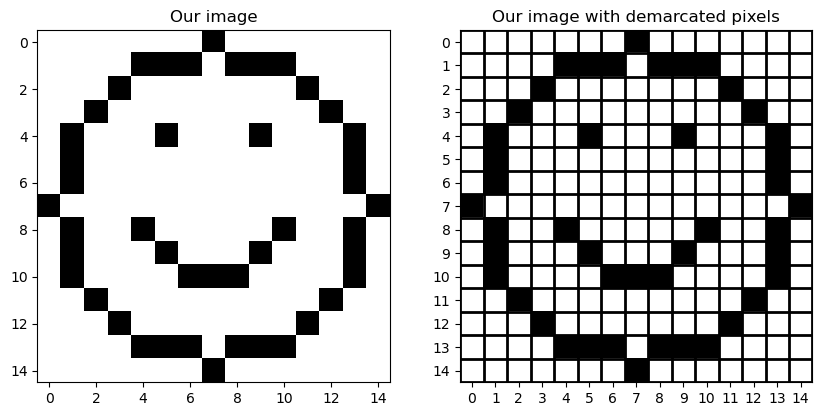

image.shape=(15, 15)


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.imshow(image,cmap='gray')
ax1.set_title('Our image')

# Plot data on the second subplot
ax2 = get_pixels(image)
ax2.set_title('Our image with demarcated pixels')

# plt.tight_layout()  # adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

print(f"{image.shape=}")

It is an array of size $15 \times 15$, consisting of 1s and 0s. Notice the indexing. It is slightly different from our $x$,$y$ cartesian coordinates, where the origin is at the bottom-left corner for when the axes are non-negative. In this notebook we use $i$ to denote the row index and $j$ to denote the column index, with origin at top-left corner.

Let us recreate this image programatically. We first begin with a blank canvas, which is just an array of 1s (for white).

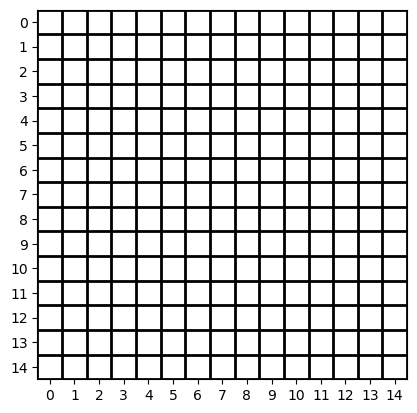

In [6]:
image = np.ones((15, 15))

ax = get_pixels(image)
plt.show()

Here is some code to add the circle outline representing the face.

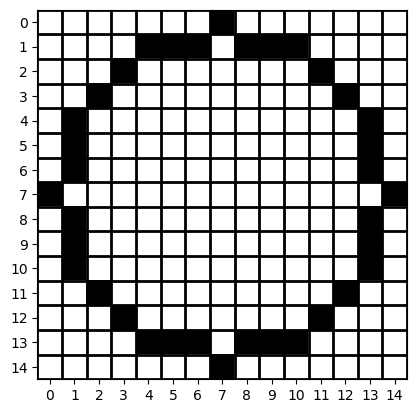

In [7]:
center = (7, 7)
radius = 7
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if (i-center[0])**2 + (j-center[1])**2 <= radius**2:
            if (i-center[0])**2 + (j-center[1])**2 > (radius-1)**2:
                image[i, j] = 0

ax = get_pixels(image)
plt.show()

Now use indexing to fill the eyes and the smile:

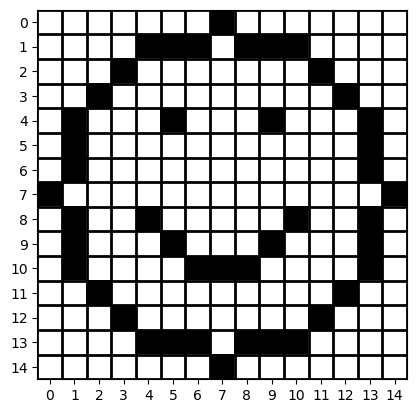

In [8]:

# Define the positions of the eyes and the smile
eye1 = (4, 5)
eye2 = (4, 9)


# Set these positions to 0 (black)
image[eye1] = 0
image[eye2] = 0

image[(10,7)] = 0
for i in range(1,4):
    image[(10-i+1, 7-i)] = 0
    image[(10-i+1, 7+i)] = 0


# Display the image
ax = get_pixels(image)
plt.show()

Now you have an idea of how images can be represented using binary arrays. Let's move on from pixel art to "real" images.

###  Grayscale Images

Grayscale images can be represented as 2D arrays, where each element (pixel) of the array corresponds to a single intensity integer value ranging from 0 (black) to 255 (white).

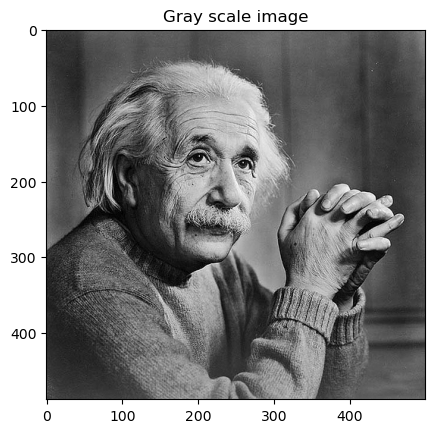

In [9]:
bw_image = cv2.imread('images/einstein.jpg', cv2.IMREAD_GRAYSCALE)

plt.title("Gray scale image")
plt.imshow(bw_image, cmap='gray')
plt.show()

Let's look into the image array further.

In [10]:
print(f"{bw_image.shape=}")
print(f"{bw_image.dtype=}")
print(f"{bw_image.max()=}")
print(f"{bw_image.min()=}")

bw_image.shape=(488, 500)
bw_image.dtype=dtype('uint8')
bw_image.max()=255
bw_image.min()=0


### Color images
Color images are represented as 3D arrays, where each element (pixel) of the array contains three values (channels) corresponding to the red, green, and blue (RGB) intensities. Each channel's intensity value ranges from 0 to 255.


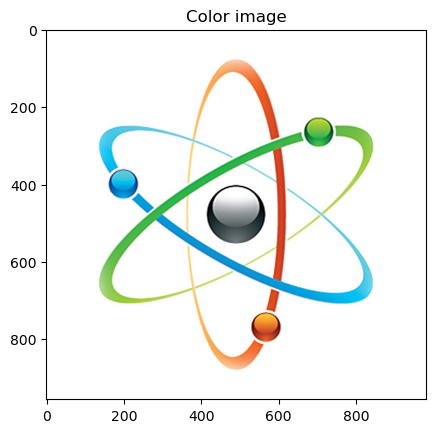

color_image.shape=(956, 981, 3)


In [11]:
color_image = cv2.imread("images/color_test.jpg")
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
plt.title("Color image")
plt.imshow(color_image)
plt.show()

print(f"{color_image.shape=}")

In [12]:
print(f"{color_image.shape=}")
print(f"{color_image.dtype=}")
print(f"{color_image.max()=}")
print(f"{color_image.min()=}")

color_image.shape=(956, 981, 3)
color_image.dtype=dtype('uint8')
color_image.max()=255
color_image.min()=0


Here the image consists of 3 2D arrays of size $956\times981$, where each 2D array consists of `int` values between 0 and 255, representing color channels Red, Green and Blue.

### Manipulating images
Since images are stored as numpy arrays, we can perform basic manipulations using array operations. In the next cell, implement some basic operations as described in the comments.

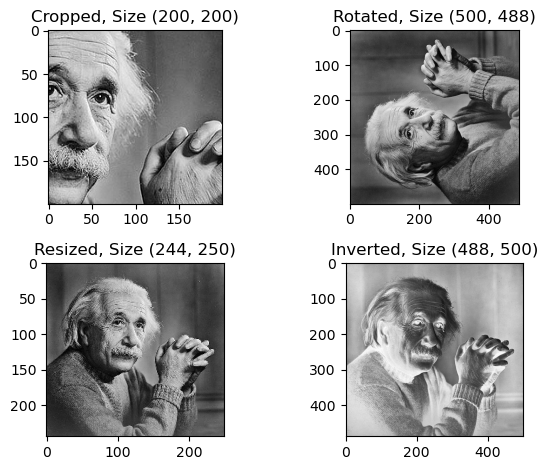

In [13]:
bw_image = cv2.imread('images/einstein.jpg', cv2.IMREAD_GRAYSCALE)
# Cropping
cropped_image = bw_image[100:300, 200:400]


# Rotation (90 degrees)
rotated_image = np.rot90(bw_image)

# Resize
resized_image = bw_image[::2, ::2]

# Invert
inverted_image = np.abs(255 - bw_image)


titles = ["Cropped", "Rotated", "Resized", "Inverted"]
images = [cropped_image, rotated_image, resized_image, inverted_image]

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"{titles[i]}, Size {images[i].shape}")
plt.tight_layout()
plt.show()

We can also manipulate colors by indexing the appropriate channel. Here is Mario:

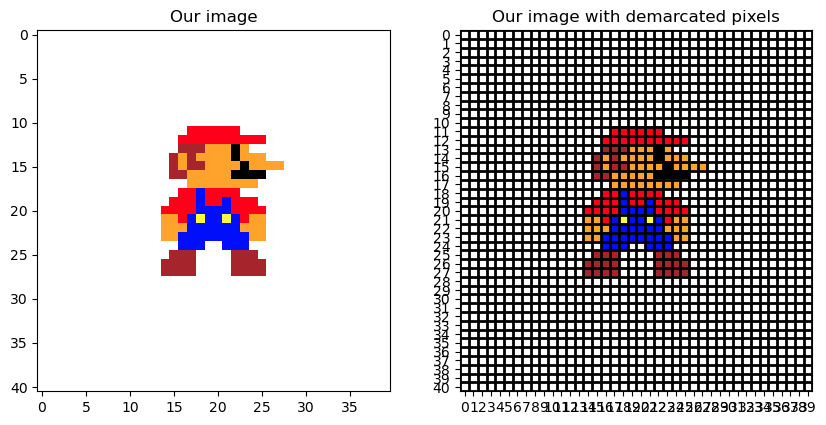

mario_image.shape=(41, 40, 3)


In [14]:
mario_image = cv2.imread('images/mario.png')
mario_image = cv2.cvtColor(mario_image, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(mario_image)
ax1.set_title('Our image')
ax2 = get_pixels(mario_image, gray=False)
ax2.set_title('Our image with demarcated pixels')
plt.show()

print(f"{mario_image.shape=}")

We want to make him look a little bit like Luigi. Let's change the color of his shirt and hat.
Let's look at the value for red from Mario's hat (eg pixel (2,6)).

In [15]:
hat_pixel = (11,18)

mario_red = mario_image[hat_pixel][:]
print(f"{mario_red=}")

mario_red=array([255,   0,  27], dtype=uint8)


We know that Luigi green is [96, 196, 69]. We want to convert all pixels that are mario_red to luigi_green.

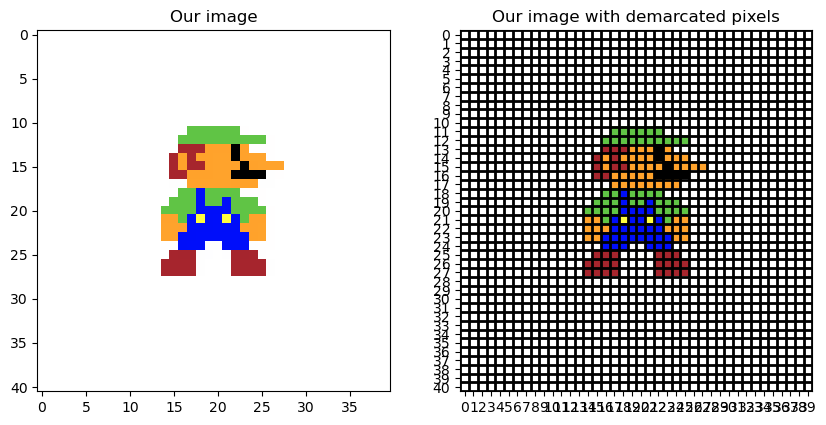

luigi_image.shape=(41, 40, 3)


In [16]:
luigi_green = [96, 196, 69]


luigi_image = mario_image

r_mask = mario_image[:,:,0] == mario_red[0]
g_mask = mario_image[:,:,1] == mario_red[1]
b_mask = mario_image[:,:,2] == mario_red[2]
combined_mask = r_mask & g_mask & b_mask
luigi_image[combined_mask] = luigi_green

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(luigi_image)
ax1.set_title('Our image')
ax2 = get_pixels(luigi_image, gray=False)
ax2.set_title('Our image with demarcated pixels')
plt.show()

print(f"{luigi_image.shape=}")

## 2. Image Processing using Linear Algebra Operations

In this section, we will explore how basic image processing operations can be performed using linear algebra operations with NumPy. Many image processing operations are done using convolution on 2D array images.




### 2.1. Grayscale Conversion

Grayscale conversion can be performed by calculating the weighted average of the RGB channels.

Mathematically, the grayscale conversion is done using the following equation:

$$
I_{gray} = 0.299 \times R + 0.587 \times G + 0.114 \times B
$$

where $I_{gray}$ is the grayscale intensity, and $R$, $G$, and $B$ are the red, green, and blue channel intensities, respectively. The specific coeffiecients are estimated using colorimetry.



Size of color image: (15, 15)
Size of grayscale image: (956, 981)


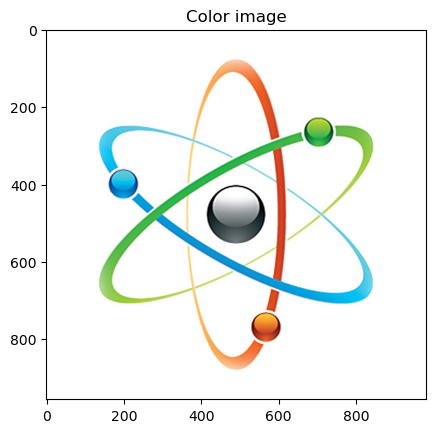

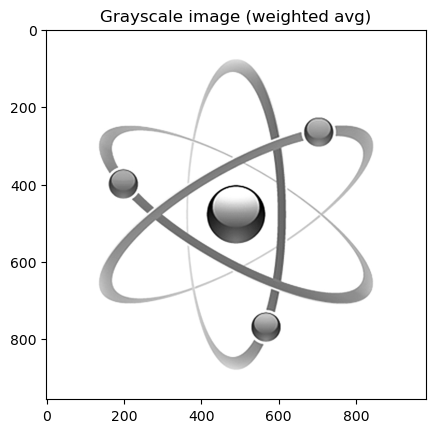

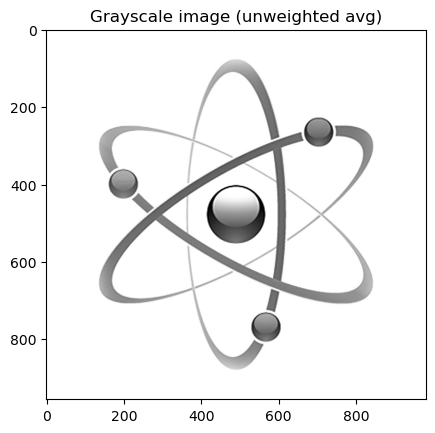

In [17]:
def convert_to_grayscale(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

color_image = cv2.imread("images/color_test.jpg")
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

gray_image = convert_to_grayscale(color_image)
avg_gray_image = np.mean(color_image,axis=2)

print(f"Size of color image: {image.shape}")
print(f"Size of grayscale image: {gray_image.shape}")

plt.title("Color image")
plt.imshow(color_image)
plt.show()
plt.title("Grayscale image (weighted avg)")
plt.imshow(gray_image, cmap="gray")
plt.show()
plt.title("Grayscale image (unweighted avg)")
plt.imshow(avg_gray_image, cmap="gray")
plt.show()



---

Now let's focus on kernel based operations.
<img src="https://github.com/williamratcliff/APS-GDS-March-2024-Data-Science-Tutorial/blob/main/CNN/images/2D_Convolution_Animation.gif?raw=1">
We define a kernel $K$ and convolve it with the image to get the desired effect $G$.
$$
G = I * K
$$

In the next sections, we will look at some of the most common kernels.


### 2.2. Edge Detection
An edge can be thought of as an area of rapid change in image intensity.

![Fig Edge detection](https://github.com/williamratcliff/APS-GDS-March-2024-Data-Science-Tutorial/blob/main/CNN/images/edge_detection.png?raw=1)

To get the edges, we need to get the gradient of an image $$\nabla f=\left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right]$$

This can be using the Sobel operator, which is a discrete differentiation operator that calculates the gradient of the image intensity.



Mathematically, the Sobel operator calculates the gradient in the $x$ and $y$ directions using the following convolution kernels:

$$
S_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}, \quad
S_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

The gradients in the $x$ and $y$ directions, $G_x$ and $G_y$, are obtained by convolving the image $I$ with the Sobel kernels $S_x$ and $S_y$, respectively:

$$
G_x = I * S_x, \quad
G_y = I * S_y
$$

The magnitude of the gradient at each pixel is calculated as:

$$
G = \sqrt{G_x^2 + G_y^2}
$$

Edges can be detected by thresholding the gradient magnitude:

$$
E(x, y) = \begin{cases}
255 & \text{if } G(x, y) \geq T_{low} \text{ and } G(x, y) \leq T_{high} \\
0 & \text{otherwise}
\end{cases}
$$

where $E(x, y)$ is the edge image, and $T_{low}$ and $T_{high}$ are the lower and upper thresholds, respectively.


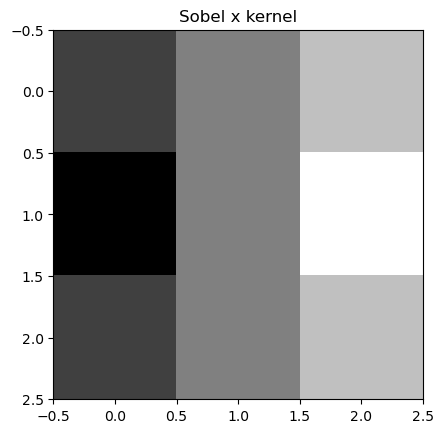

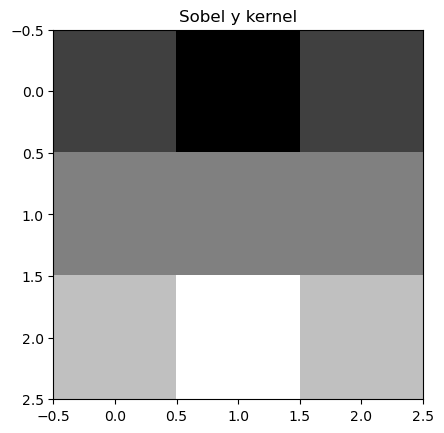

In [18]:
sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

plt.title('Sobel x kernel')
plt.imshow(sobel_x, cmap='gray')
plt.show()

plt.title('Sobel y kernel')
plt.imshow(sobel_y, cmap='gray')
plt.show()

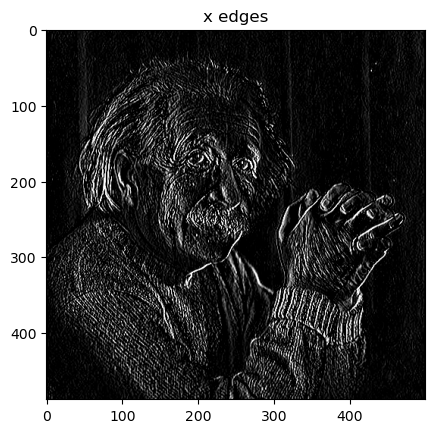

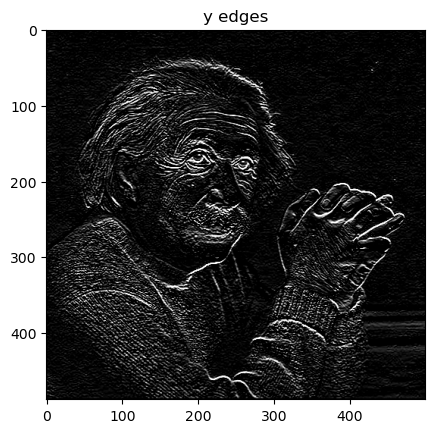

In [19]:
image = cv2.imread('images/einstein.jpg', cv2.IMREAD_GRAYSCALE)

def rescale(arr):
    arr = arr - arr.min()
    arr = arr/arr.max() * 255
    return arr.astype(int)


def sobel_operator(image):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    grad_x = cv2.filter2D(image, -1, sobel_x)
    grad_y = cv2.filter2D(image, -1, sobel_y)

    grad_x = rescale(grad_x)
    grad_y = rescale(grad_y)
    return grad_x, grad_y


grad_x, grad_y = sobel_operator(image)

plt.title("x edges")
plt.imshow(grad_x, cmap="gray")
plt.show()

plt.title("y edges")
plt.imshow(grad_y, cmap="gray")
plt.show()




We can now find the gradient magnitude for this image.

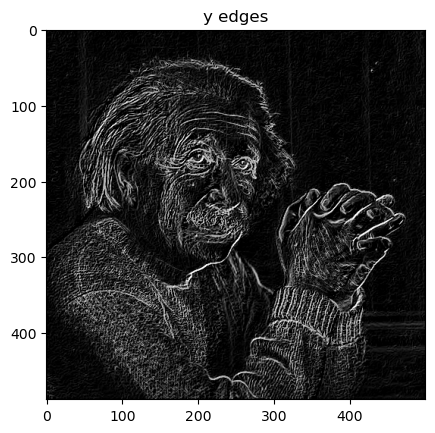

In [20]:
grad_mag = rescale(np.sqrt(grad_x**2 + grad_y**2))
plt.title("y edges")
plt.imshow(grad_mag, cmap="gray")
plt.show()

Play around with the threshold values to get good edge detection.

In [21]:
@interact(low_threshold=widgets.IntSlider(min=0, max=255, step=1, value=45), high_threshold=widgets.IntSlider(min=0, max=255, step=1, value=255))
def detect_edges(low_threshold=45, high_threshold=255, ret = False):
    edges = grad_mag
    edges = np.where((grad_mag < low_threshold) & (edges > high_threshold), image, 255).astype(np.uint8)
    edges = np.where((grad_mag >= low_threshold) & (edges <= high_threshold), image, 0).astype(np.uint8)

    plt.imshow(edges, cmap="gray")
    plt.show()

    if ret:
        return edges



interactive(children=(IntSlider(value=45, description='low_threshold', max=255), IntSlider(value=255, descript…

In practice, it is difficult to adjust and find the correct threshold values. We use the built in operations from opencv to get better edge detection.

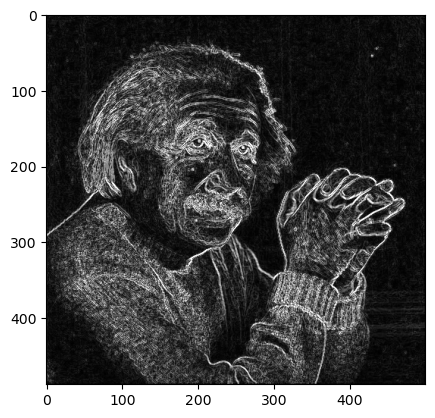

In [22]:
ddept=cv2.CV_16S
x = cv2.Sobel(image, ddept, 1,0, ksize=3, scale=1)
y = cv2.Sobel(image, ddept, 0,1, ksize=3, scale=1)
absx= cv2.convertScaleAbs(x)
absy = cv2.convertScaleAbs(y)
edge = cv2.addWeighted(absx, 0.5, absy, 0.5,0)
plt.imshow(edge, cmap='gray')

### 2.3. Image Blurring

Image blurring (also known as smoothing) is  performed by convolving the image with a low-pass filter kernel. It helps in removing noise and reducing the amount of detail in an image.

One common method for blurring images is using a Gaussian blur, which uses a Gaussian function as its convolution kernel.

Mathematically, the 2D Gaussian function is given by:

$$
G(x, y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$

where $\sigma$ is the standard deviation of the Gaussian distribution.



In [23]:
@interact(kernel_size=widgets.IntSlider(min=5, max=50, step=1, value=20), sigma=widgets.IntSlider(min=0.5, max=10.0, step=0.5, value=5))
def gaussian_blur(kernel_size=20, sigma=5, ret = False):

    ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))


    kernel = kernel / np.sum(kernel)
    blurred_image = cv2.filter2D(image, -1, kernel)

    if not ret:
        plt.title("Kernel")
        plt.imshow(kernel)
        plt.show()

        plt.title("Blurred image")
        plt.imshow(blurred_image, cmap="gray")
        plt.show()

    if ret:
        return blurred_image

# # blurred_image = gaussian_blur(image)
# plt.imshow(blurred_image, cmap="gray")
# plt.show()

interactive(children=(IntSlider(value=20, description='kernel_size', max=50, min=5), IntSlider(value=5, descri…

### 2.4. Image Sharpening
Image sharpening is performed by subtracting a blurred version of the image from the original image. This enhances the edges and increases the contrast of the image.

Mathematically, the sharpening operation can be represented as:

$$
I_{sharp} = I_{orig} + k \cdot (I_{orig} - I_{blur})
$$

where $I_{sharp}$ is the sharpened image, $I_{orig}$ is the original image, $I_{blur}$ is the blurred image, and $k$ is the sharpening factor.


In [24]:
blurred_image = gaussian_blur(5,3,True)

@interact(factor=widgets.IntSlider(min=0, max=10, step=1, value=1))
def sharpen_image(factor=1.0):
    sharpened_image = cv2.addWeighted(image, 1.0 + factor, blurred_image, -factor, 0)

    plt.title("Normal image")
    plt.imshow(image, cmap="gray")
    plt.show()

    plt.title("Blurred image")
    plt.imshow(blurred_image, cmap="gray")
    plt.show()

    plt.title("Sharpened image")
    plt.imshow(sharpened_image, cmap="gray")
    plt.show()

# sharpened_image = sharpen_image(image)
# plt.imshow(sharpened_image, cmap="gray")
# plt.show()


interactive(children=(IntSlider(value=1, description='factor', max=10), Output()), _dom_classes=('widget-inter…

##  Implementing a CNN in PyTorch

Work in progress

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0 through 9). We'll load this dataset, apply necessary transformations, and prepare loaders for training and testing.

In [26]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Let's see some examples:

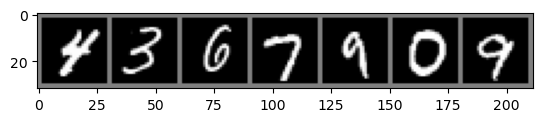

4 3 6 7 9 0 9


In [27]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:7]))
print(' '.join(f'{labels[j].item()}' for j in range(7)))

We'll define a simple CNN model for digit classification. This model will have two convolutional layers followed by two fully connected layers.

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # 1 input channel, 32 output channels, kernel size 5
        self.pool = nn.MaxPool2d(2, 2) # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 256) # 64 channels * 4x4 image size from conv2
        self.fc2 = nn.Linear(256, 10) # 10 output classes for 10 digits

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4) # Flatten layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()


We'll use Cross Entropy Loss for classification and the Adam optimizer.

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


Now, let's train the model for a few epochs, observing the loss decrease.

In [31]:
for epoch in tqdm(range(10)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Batch 100, Loss: 0.5237852961942554


Epoch 1, Batch 200, Loss: 0.14474984895437956


Epoch 1, Batch 300, Loss: 0.11791620309464633


Epoch 1, Batch 400, Loss: 0.09466348812449724


Epoch 1, Batch 500, Loss: 0.07905456902459264


Epoch 1, Batch 600, Loss: 0.0671774379722774


Epoch 1, Batch 700, Loss: 0.06355587664525957


Epoch 1, Batch 800, Loss: 0.0665326502523385


Epoch 1, Batch 900, Loss: 0.05665840030880645


938it [00:19, 46.99it/s]
 10%|█         | 1/10 [00:19<02:59, 19.96s/it]

Epoch 2, Batch 100, Loss: 0.03927131696604192


Epoch 2, Batch 200, Loss: 0.03918238122132607


Epoch 2, Batch 300, Loss: 0.04176281861960888


Epoch 2, Batch 400, Loss: 0.03863867236534133


Epoch 2, Batch 500, Loss: 0.04490740244276822


Epoch 2, Batch 600, Loss: 0.039653560421429576


Epoch 2, Batch 700, Loss: 0.045691838742932304


Epoch 2, Batch 800, Loss: 0.03844542937236838


Epoch 2, Batch 900, Loss: 0.038494636779651044


938it [00:19, 46.95it/s]
 20%|██        | 2/10 [00:39<02:39, 19.97s/it]

Epoch 3, Batch 100, Loss: 0.022911859231535346


Epoch 3, Batch 200, Loss: 0.029280227251001635


Epoch 3, Batch 300, Loss: 0.028839168062258978


Epoch 3, Batch 400, Loss: 0.02678133145032916


Epoch 3, Batch 500, Loss: 0.03252368793910136


Epoch 3, Batch 600, Loss: 0.035371516721497756


Epoch 3, Batch 700, Loss: 0.03141121370790643


Epoch 3, Batch 800, Loss: 0.01929927677003434


Epoch 3, Batch 900, Loss: 0.02799485657335026


938it [00:20, 45.42it/s]
 30%|███       | 3/10 [01:00<02:21, 20.28s/it]

Epoch 4, Batch 100, Loss: 0.016819564147735947


Epoch 4, Batch 200, Loss: 0.02099112623400288


Epoch 4, Batch 300, Loss: 0.021305815966770753


Epoch 4, Batch 400, Loss: 0.020508987428620458


Epoch 4, Batch 500, Loss: 0.025546796708367764


Epoch 4, Batch 600, Loss: 0.022812176751140213


Epoch 4, Batch 700, Loss: 0.02363183463938185


Epoch 4, Batch 800, Loss: 0.022402809183331554


Epoch 4, Batch 900, Loss: 0.021605536628921982


938it [00:20, 45.98it/s]
 40%|████      | 4/10 [01:21<02:01, 20.33s/it]

Epoch 5, Batch 100, Loss: 0.013510579892026727


Epoch 5, Batch 200, Loss: 0.013892131883258116


Epoch 5, Batch 300, Loss: 0.017165488444152287


Epoch 5, Batch 400, Loss: 0.017834268911974503


Epoch 5, Batch 500, Loss: 0.01722066554477351


Epoch 5, Batch 600, Loss: 0.016972176057242903


Epoch 5, Batch 700, Loss: 0.02465426916613069


Epoch 5, Batch 800, Loss: 0.017784504455921706


Epoch 5, Batch 900, Loss: 0.02126861567114247


938it [00:20, 45.76it/s]
 50%|█████     | 5/10 [01:41<01:41, 20.39s/it]

Epoch 6, Batch 100, Loss: 0.016059950650633256


Epoch 6, Batch 200, Loss: 0.009537340614406276


Epoch 6, Batch 300, Loss: 0.011195772682476672


Epoch 6, Batch 400, Loss: 0.013403998764515564


Epoch 6, Batch 500, Loss: 0.015762249340259587


Epoch 6, Batch 600, Loss: 0.009988896830363955


Epoch 6, Batch 700, Loss: 0.019529585621348815


Epoch 6, Batch 800, Loss: 0.013693117061247904


Epoch 6, Batch 900, Loss: 0.019780384909245184


938it [00:20, 45.89it/s]
 60%|██████    | 6/10 [02:01<01:21, 20.41s/it]

Epoch 7, Batch 100, Loss: 0.008594786038811435


Epoch 7, Batch 200, Loss: 0.00988032400207885


Epoch 7, Batch 300, Loss: 0.007082217215738638


Epoch 7, Batch 400, Loss: 0.009634679928258266


Epoch 7, Batch 500, Loss: 0.01890194785643871


Epoch 7, Batch 600, Loss: 0.01428014962883026


Epoch 7, Batch 700, Loss: 0.016906677816878074


Epoch 7, Batch 800, Loss: 0.009220952093746746


Epoch 7, Batch 900, Loss: 0.01088666457513682


938it [00:19, 47.81it/s]
 70%|███████   | 7/10 [02:21<01:00, 20.15s/it]

Epoch 8, Batch 100, Loss: 0.009718698739015963


Epoch 8, Batch 200, Loss: 0.007382356680063822


Epoch 8, Batch 300, Loss: 0.004248927194294083


Epoch 8, Batch 400, Loss: 0.00400164367985326


Epoch 8, Batch 500, Loss: 0.016229606246495224


Epoch 8, Batch 600, Loss: 0.013015325993010265


Epoch 8, Batch 700, Loss: 0.013171767055902138


Epoch 8, Batch 800, Loss: 0.01418709330713682


Epoch 8, Batch 900, Loss: 0.008027133562845847


938it [00:19, 47.10it/s]
 80%|████████  | 8/10 [02:41<00:40, 20.08s/it]

Epoch 9, Batch 100, Loss: 0.006604122089593148


Epoch 9, Batch 200, Loss: 0.005722766079497887


Epoch 9, Batch 300, Loss: 0.005039328920918251


Epoch 9, Batch 400, Loss: 0.014142356034853946


Epoch 9, Batch 500, Loss: 0.00808797894644158


Epoch 9, Batch 600, Loss: 0.013166073149031945


Epoch 9, Batch 700, Loss: 0.014040482213649738


Epoch 9, Batch 800, Loss: 0.015267033656332387


Epoch 9, Batch 900, Loss: 0.009727526694364315


938it [00:20, 46.19it/s]
 90%|█████████ | 9/10 [03:01<00:20, 20.15s/it]

Epoch 10, Batch 100, Loss: 0.007751044662727509


Epoch 10, Batch 200, Loss: 0.003914799473595849


Epoch 10, Batch 300, Loss: 0.00783750110085748


Epoch 10, Batch 400, Loss: 0.011097140488200239


Epoch 10, Batch 500, Loss: 0.00890583182977025


Epoch 10, Batch 600, Loss: 0.006310089656494711


Epoch 10, Batch 700, Loss: 0.007714019582581386


Epoch 10, Batch 800, Loss: 0.005450217706957119


Epoch 10, Batch 900, Loss: 0.005224246597258571


938it [00:20, 44.69it/s]
100%|██████████| 10/10 [03:22<00:00, 20.28s/it]

Finished Training


Finally, we'll evaluate the model's performance on the test dataset.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 99.21 %


## Examples of Physics Applications

Work in progress